# Project: Bollinger Bands Mean Reversion Strategy

When prices move far from their average (more than a few standard deviations), they tend to revert.
We’ll go long when the price dips below the lower Bollinger Band (oversold) and short when it rises above the upper band (overbought).

We’ll only take Bollinger Band mean reversion signals when the RSI confirms oversold or overbought conditions — improving signal quality and avoiding “catching falling knives.”

## Imports

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

%load_ext autoreload
%autoreload 2

## Data Setup

In [104]:
# Initialize variables
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

ticker, start_date, end_date

('AAPL', '2015-01-01', '2025-11-05')

In [288]:
# Download stock data from YFinance
df = yf.download(ticker, start=start_date, end=end_date)
df = df.droplevel(axis=1, level=1)['Close'].to_frame()
df.dropna(inplace=True)

df.tail()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2025-10-28,269.000000
2025-10-29,269.700012
2025-10-30,271.399994
2025-10-31,270.369995
2025-11-03,269.049988


## Set Indicators

In [289]:
window = 20 # The number of periods to calculate the moving average over
num_std = 2 # The number of standard deviations from the mean to set upper and lower bounds
rsi_period = 14 # The number of periods to calculate the Relative Strength Index over

In [290]:
df['MA'] = df['Close'].rolling(window).mean() # Moving average
df['STD'] = df['Close'].rolling(window).std() # Standard deviation
df['Upper'] = df['MA'] + num_std * df['STD'] # Upper bound x number of standard deviations from the mean
df['Lower'] = df['MA'] - num_std * df['STD'] # Lower bound x number of standard deviations from the mean

In [291]:
# RSI Calculation

delta = df['Close'].diff() # Change in price from the previous close
gain = np.where(delta > 0, delta, 0) # Positive price movements
loss = np.where(delta < 0, -delta, 0) # Negative price movements
avg_gain = pd.Series(gain).rolling(rsi_period).mean() # The average positive price movement over a rolling window
avg_loss = pd.Series(loss).rolling(rsi_period).mean() # The average negative price movement over a rolling window
rs = (avg_gain / avg_loss).values # Average gain/loss over a rolling window
df['RSI'] = 100 - (100 / (1 + rs)) # Relative Strength Index (RSI > 70 indicates an OVERBOUGHT stock & RSI < 30 indicates an OVERSOLD stock)

df.dropna(inplace=True)
df.head()


,Close,MA,STD,Upper,Lower,RSI
Date,,,,,,
2015-01-30,25.998573,24.552077,0.797319,26.146715,22.957439,58.434362
2015-02-02,26.324776,24.655263,0.886253,26.427770,22.882757,66.039609
2015-02-03,26.329216,24.792846,0.922969,26.638784,22.946908,64.899202
2015-02-04,26.531147,24.940414,0.954221,26.848856,23.031972,66.956203
2015-02-05,26.720522,25.080918,1.000350,27.081619,23.080217,75.500277


## Trading Logic & Backtesting

Conditions:
* Long when price < lower band AND RSI < 30 (oversold)
* Short when price > upper band AND RSI > 70 (overbought)
* Exit when price crosses back towards MA

In [ ]:
def bollinger(df_backtest,
              exit_method: str = 'bound',
              trade_fee: float = 0) -> pd.DataFrame:
    
    '''
        Function to run a full backtest on the bollinger mean reversion & RSI method with optional exit methods
        
        Parameters:
            df_backtest: 
                Pandas DataFrame containing periodic close price data

            exit_method: Optional exit strategies, default = "bound":
                Parameter options:
                    * bound - Exit LONG trades when the price crosses the lower bollinger band from below & Exit SHORT trades when the price crosses the upper bollinger band from above
                    * ma - Exit LONG & SHORT trades when the price touches the moving average
                    * single - Exit position after a single period of trading

            trade_fee: 
                Optional inclusion of trade fee losses

        Returns:
            pandas DataFrame
    '''

    if exit_method not in ['bound', 'ma', 'single']:
        raise Exception('exit_method must be one of: "bound", "ma", "single"')

    position = 0.0 # 1 = LONG, -1 = SHORT, 0 = FLAT
    df_backtest['Position'] = position # Initial FLAT (No position)
    trade_num = 0
    last_trade_num = 0
    df_backtest['Trade_Num'] = trade_num # Track all indivdual trades

    for i in range(1, len(df_backtest)):

        # Previous closing period will signal the current periods position
        prev_price = df_backtest['Close'].iloc[i-1] # Previous closing price
        prev_ma = df_backtest['MA'].iloc[i-1] # Previous closing moving average
        prev_rsi = df_backtest['RSI'].iloc[i-1] # Previous closing RSI
        prev_upper = df_backtest['Upper'].iloc[i-1] # Previous closing upper bollinger limit
        prev_lower = df_backtest['Lower'].iloc[i-1] # Previous closing lower bollinger limit

        if position != 0:
            last_trade_num = trade_num

        # Only hold position for a single period of trading
        if exit_method == 'single':
            position = 0

        # ENTRY RULES
        if position == 0: # FLAT
            if prev_price < prev_lower and prev_rsi < 30: # If price crosses the lower band & stock is undersold
                position = 1 # Open a LONG position
                trade_num = last_trade_num + 1 # Flag new trade position
            elif prev_price > prev_upper and prev_rsi > 70: # If price crosses the upper band & stock is oversold
                position = -1 # Open a SHORT position
                trade_num = last_trade_num + 1 # Flag new trade position
        # EXIT RULES
        else:
            match exit_method:
                case 'bound':
                    if position == 1 and prev_price > prev_lower: # If position is LONG and price crosses below the upper bollinger limit
                        position = 0 # Exit LONG position
                        trade_num = 0
                    elif position == -1 and prev_price < prev_upper: # If position is SHORT and price crosses above the lower bollinger limit 
                        position = 0 # Exit SHORT position
                        trade_num = 0

                case 'ma':
                    if position == 1 and prev_price >= prev_ma: #and prev_price > prev_ma:
                        position = 0 # Exit LONG when price crosses below MA
                        trade_num = 0
                    elif position == -1 and prev_price <= prev_ma: #and prev_price < prev_ma:
                        position = 0 # Exit SHORT when price crosses above MA
                        trade_num = 0

        # Period parameters will signal the position for the next trading period
        df_backtest.loc[df_backtest.index[i-1], 'Signal'] = position
        # Indicate whether we are currently in a LONG or SHORT position
        df_backtest.loc[df_backtest.index[i], 'Position'] = float(position)
        # Track trade number
        df_backtest.loc[df_backtest.index[i], 'Trade_Num'] = trade_num

    df_backtest['Return'] = df_backtest['Close'].pct_change()
    df_backtest['Strategy_Return'] = df_backtest['Position'] * df_backtest['Return']
    df_backtest['Trade_Fee'] = abs(df_backtest['Strategy_Return'] * trade_fee)
    df_backtest['Strategy'] = df_backtest['Strategy_Return'] - df_backtest['Trade_Fee']
    df_backtest['Strategy_Curve'] = (1 + df_backtest['Strategy']).cumprod()
    df_backtest['BuyHold'] = df['Return'].copy()
    df_backtest['BuyHold_Curve'] = (1 + df_backtest['BuyHold']).cumprod()

    return df_backtest
    

In [302]:
# Runing a backtest on the bollinger method using a bound exit strategy, not accounting for any trading fee losses
df_backtest = bollinger(df, exit_method='bound', trade_fee=0)
df_backtest.tail()

,Close,MA,STD,Upper,Lower,RSI,Position,Trade_Num,Signal,Return,Strategy_Return,Trade_Fee,Strategy,Strategy_Curve,Return_Curve,BuyHold,BuyHold_Curve
Date,,,,,,,,,,,,,,,,,
2025-10-28,269.000000,256.465999,6.793765,270.053528,242.878469,61.176967,0.0,0,0.0,0.000707,0.0,0.0,0.0,1.30979,10.346722,0.000707,10.346722
2025-10-29,269.700012,257.178500,7.401647,271.981794,242.375205,67.163565,0.0,0,0.0,0.002602,0.0,0.0,0.0,1.30979,10.373647,0.002602,10.373647
2025-10-30,271.399994,257.891999,8.055630,274.003258,241.780740,83.891088,0.0,0,0.0,0.006303,0.0,0.0,0.0,1.30979,10.439034,0.006303,10.439034
2025-10-31,270.369995,258.509499,8.525590,275.560680,241.458319,80.532438,0.0,0,0.0,-0.003795,-0.0,0.0,-0.0,1.30979,10.399417,-0.003795,10.399417
2025-11-03,269.049988,259.127499,8.829320,276.786138,241.468859,77.708349,0.0,0,NaN,-0.004882,-0.0,0.0,-0.0,1.30979,10.348644,-0.004882,10.348644


## Performance Evaluation

In [343]:
from typing import Union

In [372]:
def performance_metrics(df_performance,
                        performance_on: str | list[str] = ['Strategy', 'BuyHold'],
                        return_dict: bool = False) -> pd.DataFrame | dict:

    '''
    Function to evaluate backtested performance on given strategies
    '''

    performance_dict = {}

    if type(performance_on) == str:
        performance_on = [performance_on]

    for method in performance_on:

        strategy = df_performance[method]
        strat_total_return = df_performance[f'{method}_Curve'].iloc[-1] - 1
        strat_cagr = (df_performance[f'{method}_Curve'].iloc[-1]) ** (252 / len(df_performance)) - 1
        strat_risk = strategy.std() * np.sqrt(252)
        strat_return = strategy.mean() * 252
        strat_sharpe = strat_return / strat_risk
        strat_max_dd = (df_performance[f'{method}_Curve'].cummax() - df_performance[f'{method}_Curve']).max()

        performance_dict[method] = {
            'Total Return': f'{strat_total_return:.2%}',
            'Annual Return': round(strat_return,2),
            'Annual Risk': round(strat_risk,2),
            'Sharpe Ratio': round(strat_sharpe, 2),
            'CAGR': f'{strat_cagr:.2%}',
            'Max Drawdown': f'{strat_max_dd:.2%}'
            }
    if return_dict:
        return performance_dict
    else:
        return pd.DataFrame.from_dict(performance_dict, orient='Index')

In [373]:
performance_metrics(df_backtest)

,Total Return,Annual Return,Annual Risk,Sharpe Ratio,CAGR,Max Drawdown
Strategy,30.98%,0.03,0.09,0.32,2.54%,18.41%
BuyHold,934.86%,0.26,0.29,0.90,24.30%,331.19%


### Trade Statistics

In [421]:
df_backtest.groupby('Position').count().div(len(df_backtest))['Close']

Position
-1.0    0.040635
 0.0    0.930920
 1.0    0.028445
Name: Close, dtype: float64

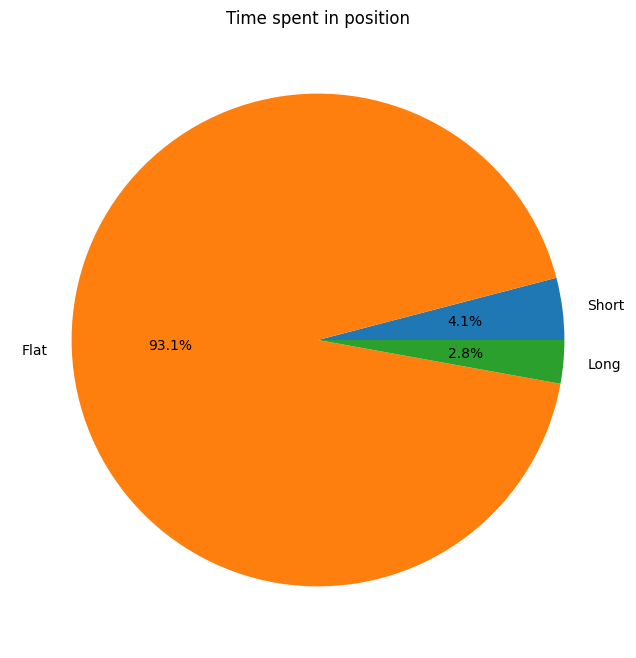

In [436]:
fig, ax = plt.subplots(figsize=(8,8))

ax.set_title('Time spent in position')
ax.pie(df_backtest.groupby('Position').count()['Close'], labels=['Short', 'Flat', 'Long'], autopct='%1.1f%%')
plt.show;

In [437]:
df_trades = df_backtest[df_backtest['Position']!=0].groupby('Trade_Num').mean()
df_trades

,Close,MA,STD,Upper,Lower,RSI,Position,Signal,Return,Strategy_Return,Trade_Fee,Strategy,Strategy_Curve,Return_Curve,BuyHold,BuyHold_Curve
Trade_Num,,,,,,,,,,,,,,,,
1,29.086468,28.335243,0.488459,29.312161,27.358325,65.327574,-1.0,0.00,-0.015756,0.015756,0.0,0.015756,1.015756,1.118772,-0.015756,1.118772
2,27.579330,28.199909,0.455255,29.110418,27.289400,40.808462,1.0,0.00,0.026734,0.026734,0.0,0.026734,1.042911,1.060802,0.026734,1.060802
3,25.816473,27.724297,1.026727,29.777752,25.670842,21.462953,1.0,0.00,0.006629,0.006629,0.0,0.006629,1.049825,0.992996,0.006629,0.992996
4,25.906359,25.162859,0.549261,26.261381,24.064337,59.429963,-1.0,0.00,-0.031911,0.031911,0.0,0.031911,1.083327,0.996453,-0.031911,0.996453
5,25.128048,26.290112,0.599358,27.488828,25.091396,31.549946,1.0,0.00,0.007693,0.007693,0.0,0.007693,1.091661,0.966516,0.007693,0.966516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,214.721909,236.923322,9.294728,255.512778,218.333865,20.635923,1.0,0.75,-0.015535,-0.015535,0.0,-0.015535,1.171162,8.258988,-0.015535,8.258988
97,185.181717,210.874086,14.721124,240.316333,181.431839,32.739822,1.0,0.50,0.051735,0.051735,0.0,0.051735,1.188326,7.122765,0.051735,7.122765
98,211.509956,201.961791,4.908740,211.779271,192.144312,73.733700,-1.0,-0.50,-0.005816,0.005816,0.0,0.005816,1.276942,8.135445,-0.005816,8.135445


In [454]:
(df_trades['Strategy'] > 0).value_counts()

Strategy
True     61
False    39
Name: count, dtype: int64

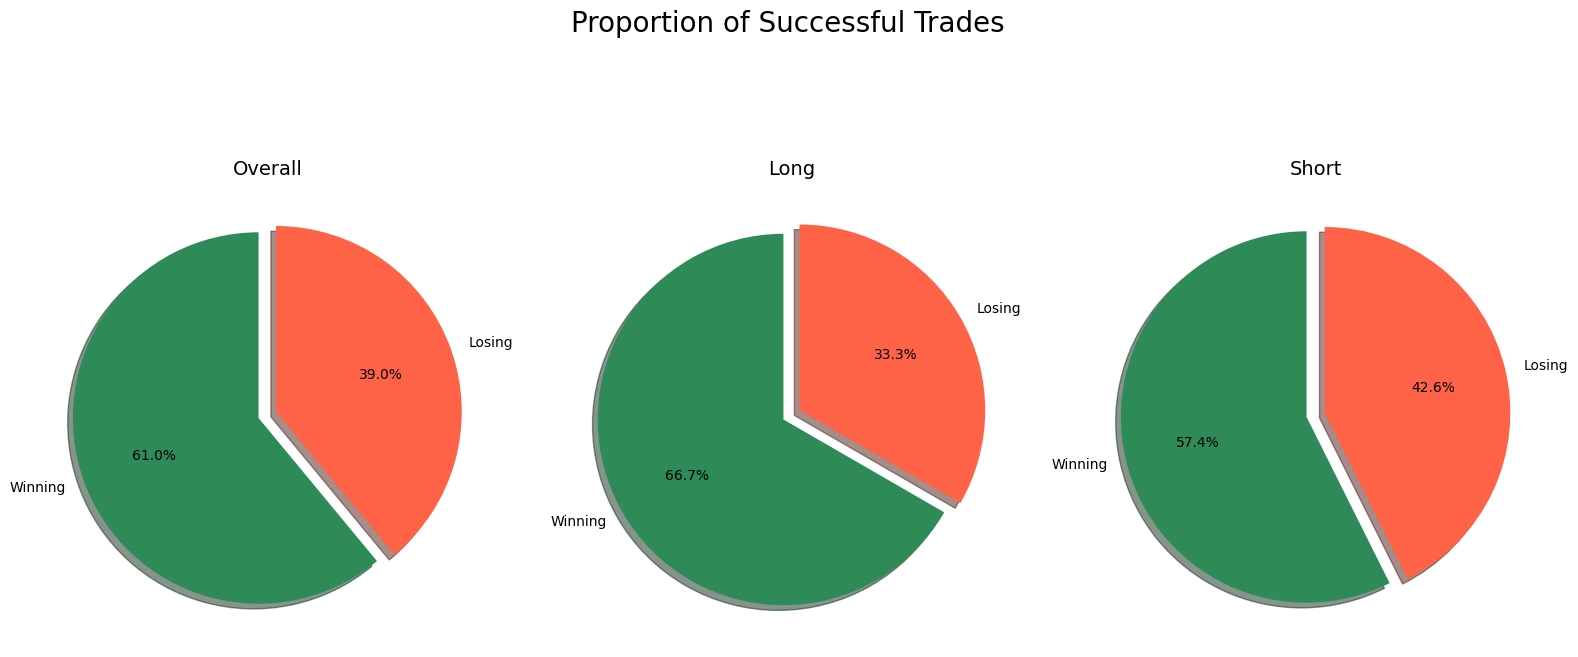

In [511]:
fig, ax = plt.subplots(1, 3, figsize=(16,8), tight_layout=True)

fig.suptitle('Proportion of Successful Trades', fontsize=20)

ax[0].set_title('Overall', fontsize=14)
ax[0].pie((df_trades['Strategy'] > 0).value_counts(),
           labels=['Winning', 'Losing'],
           autopct='%1.1f%%',
           colors=['seagreen', 'tomato'],
           explode=[0.05, 0.05],
           shadow=True,
           startangle=90)

ax[1].set_title('Long', fontsize=14)
ax[1].pie((df_trades[df_trades['Position']==1]['Strategy'] > 0).value_counts(),
           labels=['Winning', 'Losing'],
           autopct='%1.1f%%',
           colors=['seagreen', 'tomato'],
           explode=[0.05, 0.05],
           shadow=True,
           startangle=90)

ax[2].set_title('Short', fontsize=14)
ax[2].pie((df_trades[df_trades['Position']==-1]['Strategy'] > 0).value_counts(),
           labels=['Winning', 'Losing'],
           autopct='%1.1f%%',
           colors=['seagreen', 'tomato'],
           explode=[0.05, 0.05],
           shadow=True,
           startangle=90)

plt.show()

## Visualization

### Bollinger Bands Plot With Long/Short Signals

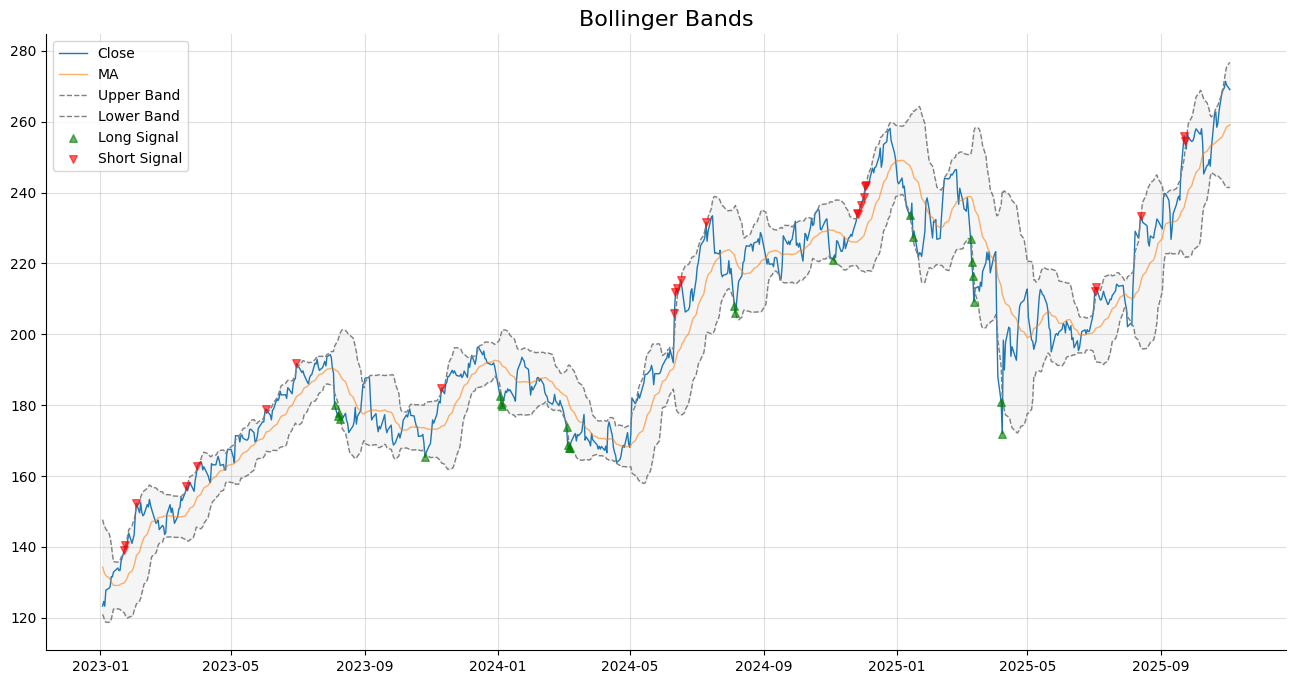

In [385]:
def plot_bands(df):

    fig, ax = plt.subplots(figsize=(16,8))
    ax.set_title('Bollinger Bands', fontsize=16)
    ax.plot(df['Close'], label = 'Close', linewidth=1)
    ax.plot(df['MA'], label = 'MA', linewidth=1, alpha=0.6)
    ax.plot(df['Upper'], label = 'Upper Band', linestyle='--', color='grey', linewidth=1)
    ax.plot(df['Lower'], label = 'Lower Band', linestyle='--', color='grey', linewidth=1)
    ax.fill_between(df.index, df['Upper'], df['Lower'], color='grey', alpha=0.075)


    ax.scatter(x=df[df['Signal']==1].index, y=df[df['Signal']==1]['Close'].loc[df[df['Signal']==1].index], marker='^', s=30, color='Green', label='Long Signal', zorder=4, alpha=0.6)
    ax.scatter(x=df[df['Signal']==-1].index, y=df[df['Signal']==-1]['Close'].loc[df[df['Signal']==-1].index], marker='v', s=30, color='Red', label='Short Signal', zorder=4, alpha=0.6)

    ax.grid(True, alpha=0.4)
    ax.spines[['top', 'right']].set_visible(False)
    ax.legend()

    return plt.show()

plot_bands(df_backtest.loc['2023':])

### RSI Plot

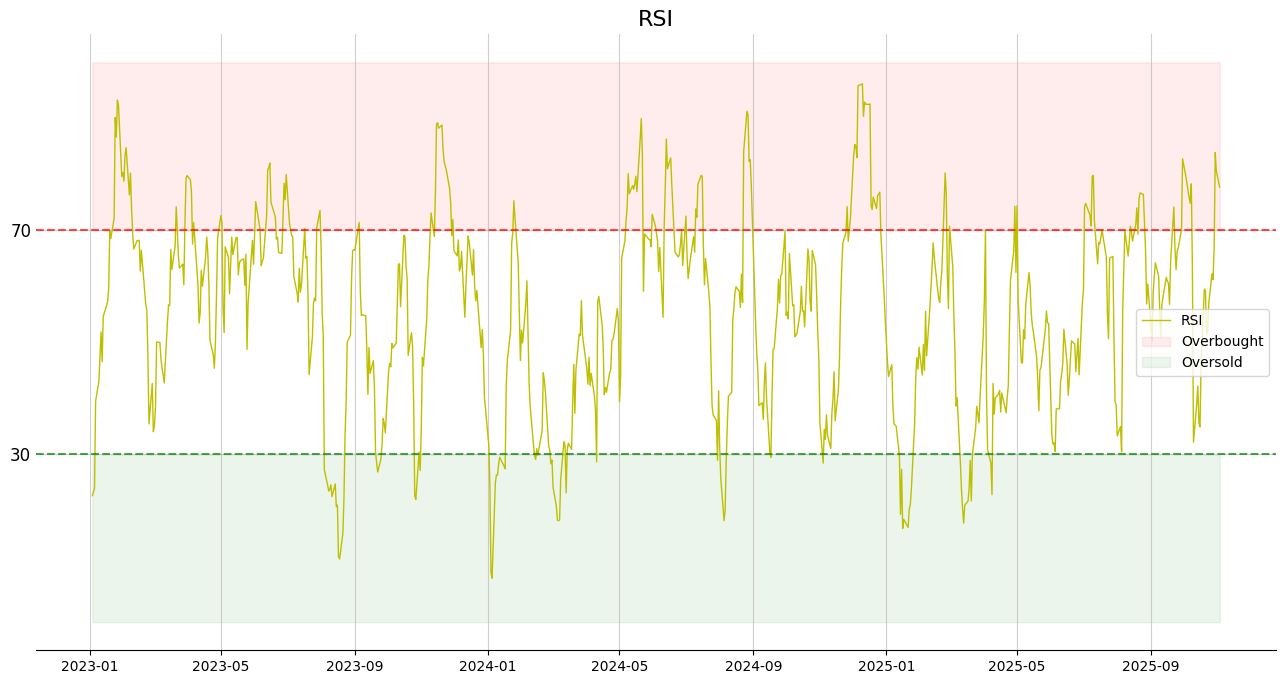

In [386]:
def plot_rsi(df):

    fig, ax = plt.subplots(figsize=(16,8))
    ax.set_title('RSI', fontsize=16)
    ax.plot(df['RSI'], label = 'RSI', linewidth=1, color='y')
    ax.axhline(70, color="r", linestyle="--", alpha=0.7)
    ax.axhline(30, color="g", linestyle="--", alpha=0.7)
    ax.fill_between(df.index, 70, 100, color='r', alpha=0.075, label='Overbought')
    ax.fill_between(df.index, 0, 30, color='g', alpha=0.075, label='Oversold')

    ax.grid(True, alpha=0.6)

    ax.spines[['top', 'right', 'left']].set_visible(False)
    ax.legend()
    
    ax.set_yticks([30,70])
    ax.tick_params(axis='y', labelsize=12, length=0)

    return plt.show()

plot_rsi(df_backtest.loc['2023':])


### Strategy vs Buy&Hold

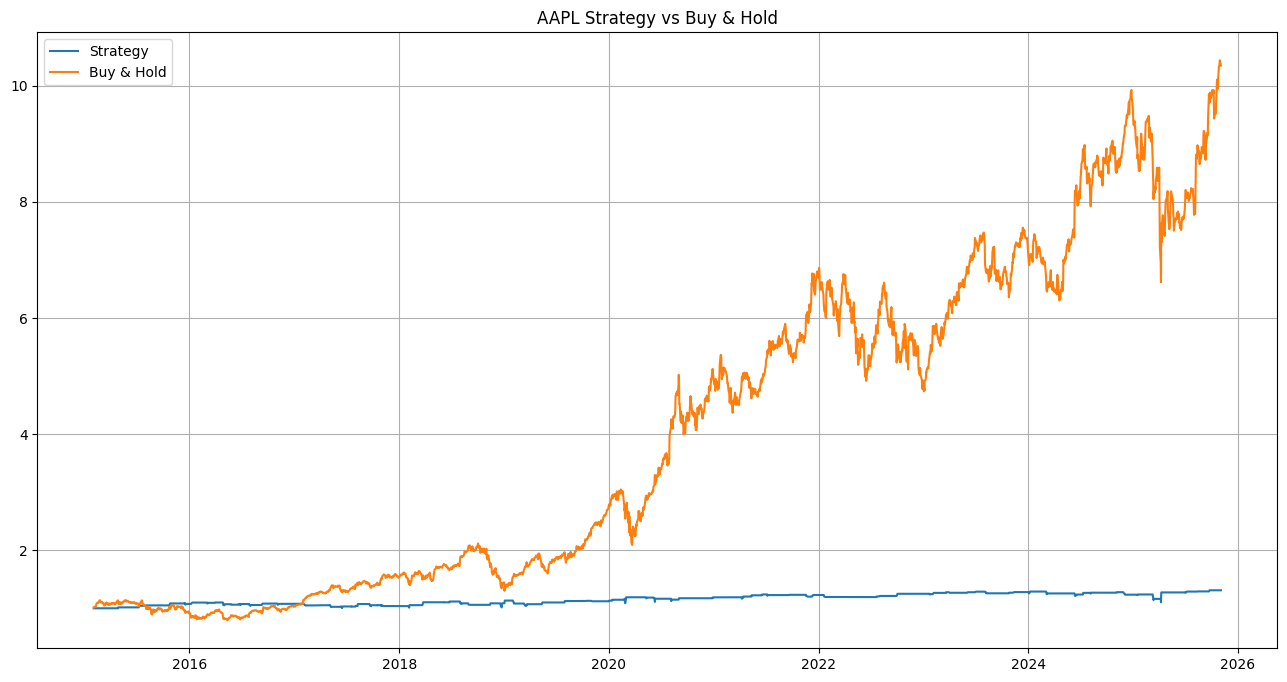

In [388]:
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(df["Strategy_Curve"], label="Strategy")
plt.plot(df["BuyHold_Curve"], label="Buy & Hold")
plt.title(f"{ticker} Strategy vs Buy & Hold")
plt.legend()
plt.grid(True)
plt.show()